# Image Classification

In this notebook, we will be building a decision tree and a multi-class logistic regression model to determine the number written in a handwritten image from the MNIST Dataset.

## Code Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.linear_model import LogisticRegression
from sklearn import tree
import joblib
from azureml.core import Run


In [2]:
import gzip
import struct


# load compressed MNIST gz files and return numpy arrays
def load_data(filename, label=False):
    with gzip.open(filename) as gz:
        struct.unpack('I', gz.read(4))
        n_items = struct.unpack('>I', gz.read(4))
        if not label:
            n_rows = struct.unpack('>I', gz.read(4))[0]
            n_cols = struct.unpack('>I', gz.read(4))[0]
            res = np.frombuffer(gz.read(n_items[0] * n_rows * n_cols), dtype=np.uint8)
            res = res.reshape(n_items[0], n_rows * n_cols)
        else:
            res = np.frombuffer(gz.read(n_items[0]), dtype=np.uint8)
            res = res.reshape(n_items[0], 1)
    return res


# one-hot encode a 1-D array
def one_hot_encode(array, num_of_classes):
    return np.eye(num_of_classes)[array.reshape(-1)]

## Explore data

### Download the MNIST dataset

Use Azure Open Datasets to get the raw MNIST data files. [Azure Open Datasets](https://docs.microsoft.com/azure/open-datasets/overview-what-are-open-datasets) are curated public datasets that you can use to add scenario-specific features to machine learning solutions for more accurate models. Each dataset has a corrseponding class, `MNIST` in this case, to retrieve the data in different ways.

This code retrieves the data as a `FileDataset` object, which is a subclass of `Dataset`. A `FileDataset` references single or multiple files of any format in your datastores or public urls. The class provides you with the ability to download or mount the files to your compute by creating a reference to the data source location. Additionally, you register the Dataset to your workspace for easy retrieval during training.

Follow the [how-to](https://aka.ms/azureml/howto/createdatasets) to learn more about Datasets and their usage in the SDK.

In [3]:
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/sharonxu-ci3/code/Users/sharonxu/mlads/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/sharonxu-ci3/code/Users/sharonxu/mlads/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/sharonxu-ci3/code/Users/sharonxu/mlads/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/sharonxu-ci3/code/Users/sharonxu/mlads/data/https%3A/%2Fazureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz']

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

In [15]:
# make sure utils.py is in the same directory as this code
# from utils import load_data
import glob

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder,"**/train-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

In [16]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

(60000, 784)
(60000,)
(10000, 784)
(10000,)


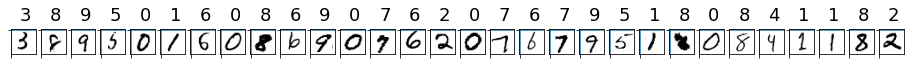

In [17]:
# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

## Training the Model


### Train the Decision Tree

In [18]:
#Train the model
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)

In [19]:
#predict results
y_hat_tree = clf_tree.predict(X_test)

In [20]:
#Find accuracy
acc = np.average(y_hat_tree == y_test)
print('Accuracy is', acc)

Accuracy is 0.8767


### Train Logistic Regression Model

In [10]:
# set regularization rate
reg = 0.5

print('Train a logistic regression model with regularization rate of', reg)
clf = LogisticRegression(C=1.0/reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

Train a logistic regression model with regularization rate of 0.5


LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# predict the test set
y_hat = clf.predict(X_test)

In [12]:
# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

Accuracy is 0.9193


## Output the Model

In [13]:
# get hold of the current run
run = Run.get_context()

run.log('regularization rate', np.float(reg))
run.log('accuracy', np.float(acc))

Attempted to log scalar metric regularization rate:
0.5
Attempted to log scalar metric accuracy:
0.9193


In [14]:
os.makedirs('outputs', exist_ok=True)

# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

['outputs/sklearn_mnist_model.pkl']